<a href="https://www.kaggle.com/code/priyankapalshetkar/playground-s3-e5?scriptVersionId=118398367" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wine-quality-dataset/WineQT.csv
/kaggle/input/playground-series-s3e5/sample_submission.csv
/kaggle/input/playground-series-s3e5/train.csv
/kaggle/input/playground-series-s3e5/test.csv


## Must Know Things before moving on

#### Goal - The dataset describes the amount of various chemicals present in wine and their effect on it's quality. Our goal is to predict the quality (on a score of 0-10) of wine using the given data.


* Kappa Co-efficient - https://medium.com/x8-the-ai-community/kappa-coefficient-for-dummies-84d98b6f13ee
* Sklearn metric reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html
* Information on original dataset - https://www.kaggle.com/datasets/yasserh/wine-quality-dataset
* Stratified k-fold Cross-validation - When we are dealing with classification problem of imbalance class distribution, we have to use StratifiedKFold.
https://towardsdatascience.com/what-is-stratified-cross-validation-in-machine-learning-8844f3e7ae8e
* Kurtosis - https://www.scribbr.com/statistics/kurtosis/

## Setup

In [2]:
from IPython.display import clear_output
!pip3 install -U lazypredict
!pip3 install -U pandas #Upgrading pandas

clear_output()

In [2]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from typing import List, Union, Tuple

# Metric import
from sklearn.metrics import cohen_kappa_score

# Preprocessing imports
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer

# Modeling imports
from sklearn.model_selection import train_test_split
# from lazypredict.Supervised import LazyClassifier
from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
import optuna
from optuna.samplers import TPESampler

# Palette
palette = sns.color_palette('plasma')

# Suppress Warnings
import warnings
warnings.simplefilter('ignore')

In [3]:
SEED = 42

def seed_everything(seed = 42):
    import random, os
    import numpy as np

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

In [4]:
train_df = pd.read_csv("/kaggle/input/playground-series-s3e5/train.csv", index_col='Id')
test_df = pd.read_csv("/kaggle/input/playground-series-s3e5/test.csv", index_col='Id')
original_df = pd.read_csv("/kaggle/input/wine-quality-dataset/WineQT.csv", index_col='Id')
sample_submission = pd.read_csv("/kaggle/input/playground-series-s3e5/sample_submission.csv")

## Exploratory Data Analysis

In [20]:
display(train_df.info())
display(test_df.info())
display(original_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2056 entries, 0 to 2055
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         2056 non-null   float64
 1   volatile acidity      2056 non-null   float64
 2   citric acid           2056 non-null   float64
 3   residual sugar        2056 non-null   float64
 4   chlorides             2056 non-null   float64
 5   free sulfur dioxide   2056 non-null   float64
 6   total sulfur dioxide  2056 non-null   float64
 7   density               2056 non-null   float64
 8   pH                    2056 non-null   float64
 9   sulphates             2056 non-null   float64
 10  alcohol               2056 non-null   float64
 11  quality               2056 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 208.8 KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1372 entries, 2056 to 3427
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1372 non-null   float64
 1   volatile acidity      1372 non-null   float64
 2   citric acid           1372 non-null   float64
 3   residual sugar        1372 non-null   float64
 4   chlorides             1372 non-null   float64
 5   free sulfur dioxide   1372 non-null   float64
 6   total sulfur dioxide  1372 non-null   float64
 7   density               1372 non-null   float64
 8   pH                    1372 non-null   float64
 9   sulphates             1372 non-null   float64
 10  alcohol               1372 non-null   float64
dtypes: float64(11)
memory usage: 128.6 KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1143 entries, 0 to 1597
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 116.1 KB


None

In [21]:
display(train_df.head())
display(test_df.head())
display(original_df.head())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6
2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7
3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5
4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
Id,,,,,,,,,,,
2056,7.2,0.510,0.01,2.0,0.077,31.0,54.0,0.99748,3.39,0.59,9.8
2057,7.2,0.755,0.15,2.0,0.102,14.0,35.0,0.99586,3.33,0.68,10.0
2058,8.4,0.460,0.40,2.0,0.065,21.0,50.0,0.99774,3.08,0.65,9.5
2059,8.0,0.470,0.40,1.8,0.056,14.0,25.0,0.99480,3.30,0.65,11.7
2060,6.5,0.340,0.32,2.1,0.044,8.0,94.0,0.99356,3.23,0.48,12.8


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
TARGET = 'quality'
pd.concat([
    pd.DataFrame(train_df.drop(columns=[TARGET]).isnull().sum(), columns=['missing train']),
    pd.DataFrame(test_df.isnull().sum(), columns=['missing test']),
    pd.DataFrame(original_df.drop(columns=[TARGET]).isnull().sum(), columns=['missing original'])
], axis=1)

,missing train,missing test,missing original
fixed acidity,0,0,0
volatile acidity,0,0,0
citric acid,0,0,0
residual sugar,0,0,0
chlorides,0,0,0
free sulfur dioxide,0,0,0
total sulfur dioxide,0,0,0
density,0,0,0
pH,0,0,0
sulphates,0,0,0


In [7]:
print("Number of Duplicates in train:",train_df.duplicated().sum())
print("Number of Duplicates in test:",test_df.duplicated().sum())
print("Number of Duplicates in original:",original_df.duplicated().sum())

Number of Duplicates in train: 0
Number of Duplicates in test: 0
Number of Duplicates in original: 125


### Observations so far:
* No Null Values in Dataset
* All Numerical Columns
* Target Variable is an integer value
* Fewer samples in dataset
* Original dataset has duplicates: Ideally these should be dropped but since we have fewer samples will retain the same

### Features Descriptions
* Fixed acidity : most acids involved with wine or fixed or nonvolatile (do not evaporate readily).

* Volatile acidity : the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste.

* Citric acid : found in small quantities, citric acid can add 'freshness' and flavor to wines.

* Residual sugar : the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet.

* Chlorides : the amount of salt in the wine.

* Free sulfur dioxide : the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine.

* Total sulfur dioxide : amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine.

* Density : the density of wine is close to that of water depending on the percent alcohol and sugar content.

* pH : describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale.

* Sulphates : a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant.

* Alcohol : the percent alcohol content of the wine.

* Quality : wine quality rating

In [31]:
display(train_df.describe())
display(test_df.describe())
display(original_df.describe())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000
mean,8.365175,0.527601,0.265058,2.398881,0.081856,16.955982,49.236868,0.996748,3.310569,0.641308,10.414972,5.720817
std,1.705390,0.173164,0.188267,0.858824,0.023729,10.009710,32.961141,0.001827,0.142321,0.137942,1.028825,0.853146
min,5.000000,0.180000,0.000000,1.200000,0.012000,1.000000,7.000000,0.990070,2.740000,0.390000,8.700000,3.000000
25%,7.200000,0.390000,0.090000,1.900000,0.071000,8.000000,22.000000,0.995600,3.200000,0.550000,9.500000,5.000000
50%,7.950000,0.520000,0.250000,2.200000,0.079000,16.000000,44.000000,0.996700,3.310000,0.610000,10.100000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,24.000000,65.000000,0.997800,3.390000,0.720000,11.000000,6.000000
max,15.900000,1.580000,0.760000,14.000000,0.414000,68.000000,289.000000,1.003690,3.780000,1.950000,14.000000,8.000000


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,8.369606,0.524311,0.270569,2.415926,0.081307,17.162536,49.089286,0.996670,3.312223,0.647267,10.473081
std,1.664694,0.176942,0.185731,0.921155,0.026566,9.974082,32.803721,0.001822,0.141405,0.134792,1.027170
min,4.900000,0.120000,0.000000,1.300000,0.012000,1.000000,8.000000,0.990070,2.740000,0.390000,8.800000
25%,7.100000,0.390000,0.110000,2.000000,0.070000,8.000000,23.000000,0.995380,3.210000,0.550000,9.600000
50%,7.900000,0.500000,0.260000,2.200000,0.078000,16.000000,43.000000,0.996600,3.310000,0.620000,10.200000
75%,9.100000,0.635000,0.420000,2.500000,0.087000,24.000000,66.000000,0.997800,3.390000,0.730000,11.200000
max,15.600000,1.330000,0.760000,8.300000,0.467000,68.000000,165.000000,1.003200,4.010000,1.620000,14.000000


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


#### Distribution of each of the columns

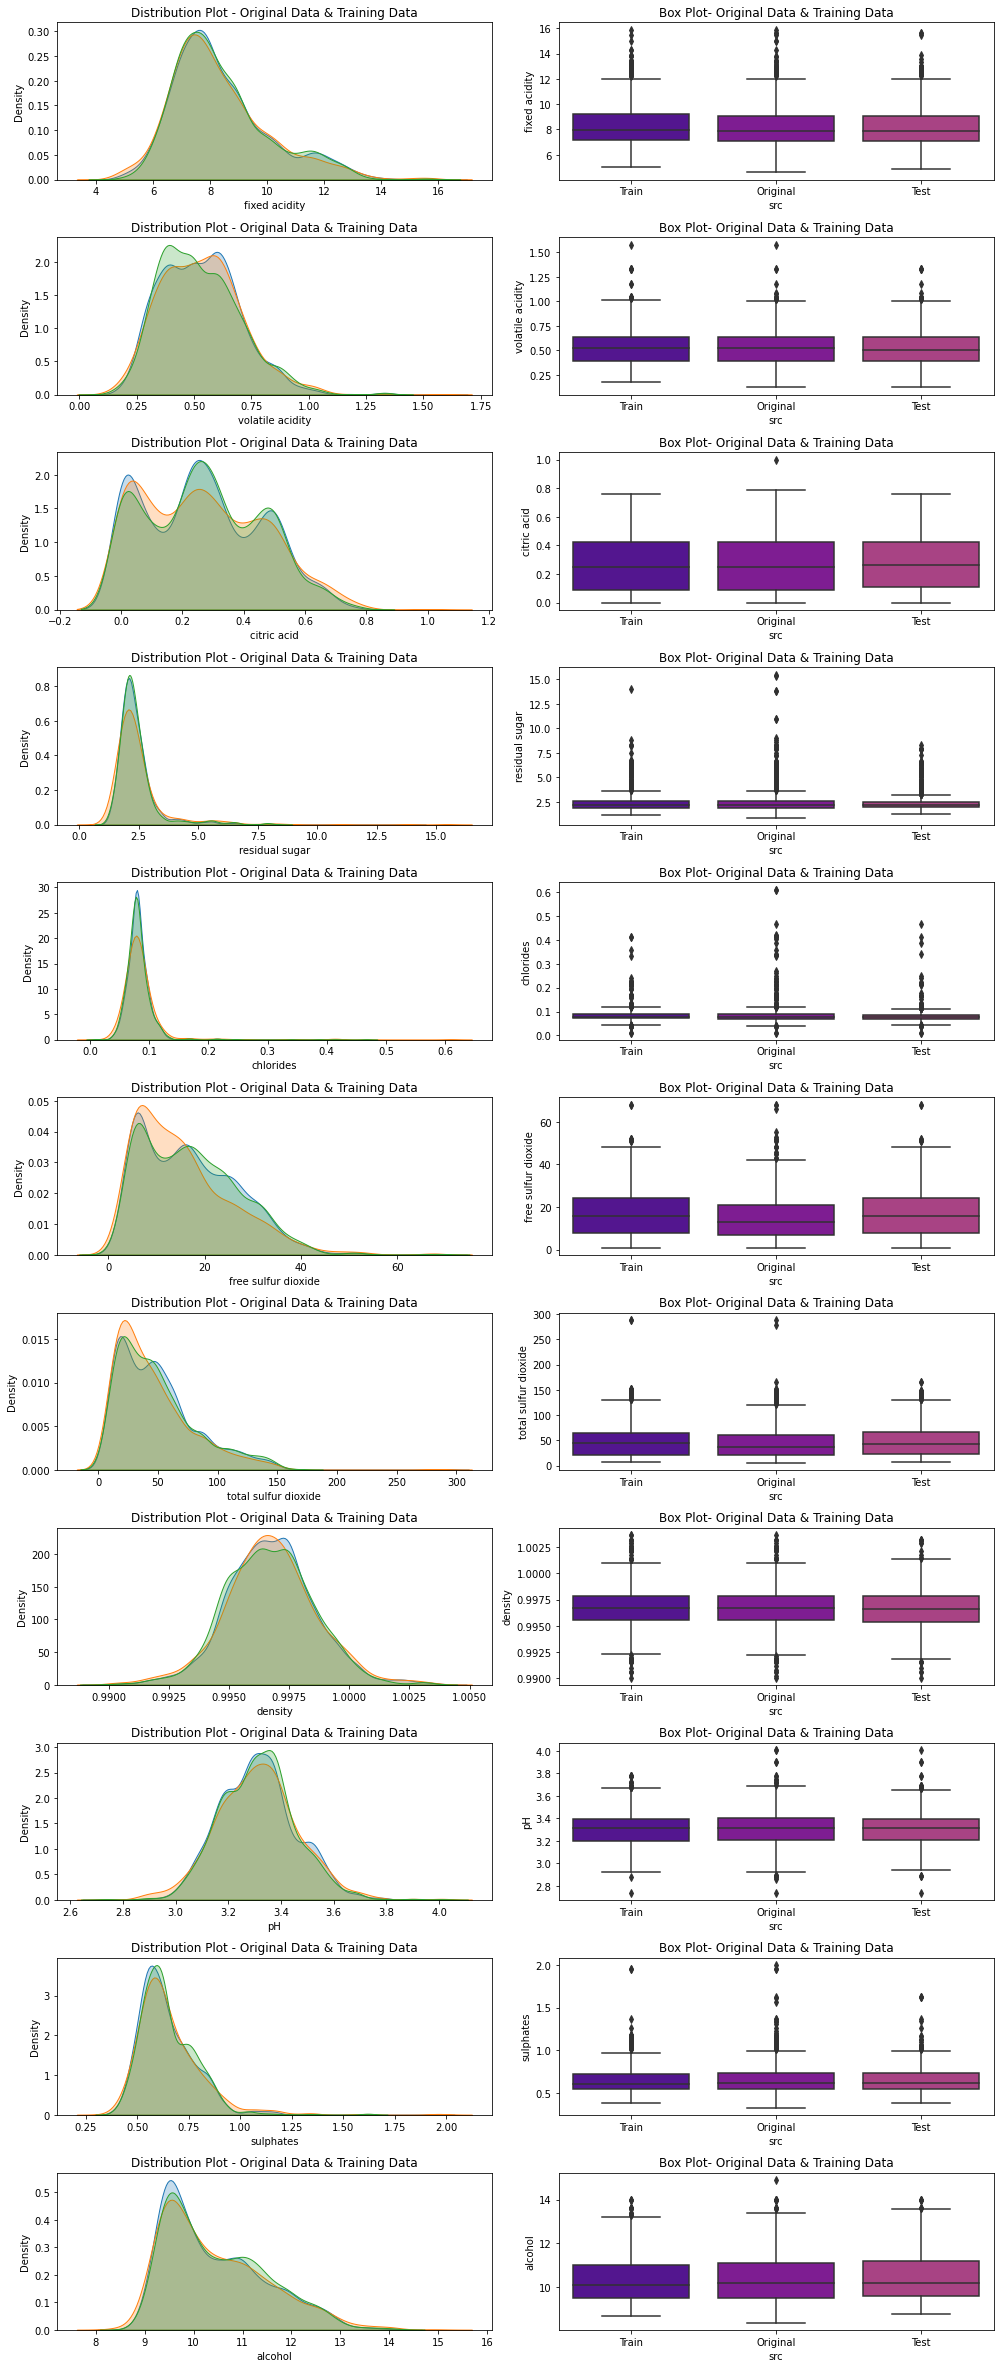

In [6]:
ncols = 2
features=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']

nrows = len(features)
df_temp=pd.concat([train_df.assign(src='Train'),original_df.assign(src='Original'),test_df.assign(src='Test')])
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3*nrows))

for r in range(nrows):
    row = features[r]
   
    sns.kdeplot(x=train_df[row], ax=axes[r,0], palette=palette, label='Train data', fill =True)
    sns.kdeplot(x=original_df[row], ax=axes[r,0], palette=palette, label='Original data' , fill =True )
    sns.kdeplot(x=test_df[row], ax=axes[r,0], palette=palette, label='Test data', fill =True)
    
    sns.boxplot(data=df_temp, y=row,x='src' ,ax=axes[r,1],palette=palette)


    axes[r,0].title.set_text("Distribution Plot - Original Data & Training Data")
    axes[r,1].title.set_text("Box Plot- Original Data & Training Data")
fig.tight_layout()
plt.show()

#### Insight:
* All variables except Quality are continuous.
* Original and Training Data follow the same distribution so they can be combined.
* Some columns - chlorides, residual sugar, sulphates are skewed
* We can also see the presence of outliers in some of the columns.

#### Combining original and train datasets

In [7]:
combined_df = pd.concat([train_df, original_df], ignore_index=True)

## Skewness

#### Zooming in on the skewness

In [8]:
# We concatenate test data to train to get a full view of the data as we know it
skew_df = pd.concat((combined_df.drop(TARGET,axis =1), test_df), axis =0).skew(numeric_only=True).sort_values()
print("Skewly distributed columns by skewness value:\n") 
display(skew_df)

Skewly distributed columns by skewness value:



density                 0.147377
pH                      0.232995
citric acid             0.271634
volatile acidity        0.697208
alcohol                 0.789138
free sulfur dioxide     0.826404
fixed acidity           0.991695
total sulfur dioxide    1.308484
sulphates               2.086318
residual sugar          4.288313
chlorides               7.016995
dtype: float64

#### Zooming in on Kurtosis

In [9]:
kurtosis_df = pd.concat((combined_df.drop(TARGET,axis =1), test_df), axis =0).kurtosis().sort_values()
print("Tailed columns by kurtosis value\n") 
display(kurtosis_df)

Tailed columns by kurtosis value



citric acid             -0.821532
alcohol                 -0.097520
pH                       0.542226
free sulfur dioxide      0.686953
density                  0.765202
fixed acidity            0.930621
volatile acidity         1.160855
total sulfur dioxide     2.678366
sulphates               10.576394
residual sugar          30.692751
chlorides               76.649309
dtype: float64

#### Removing Skewness & Kurtosis 
Exploring Potential Solutions for columns = sulphates, residual sugar, chlorides:
* Log transform
* Scaling (Quantile)
* BoxCox
* Cube root / Square root

In [10]:
affected_cols = ['sulphates', 'residual sugar', 'chlorides']

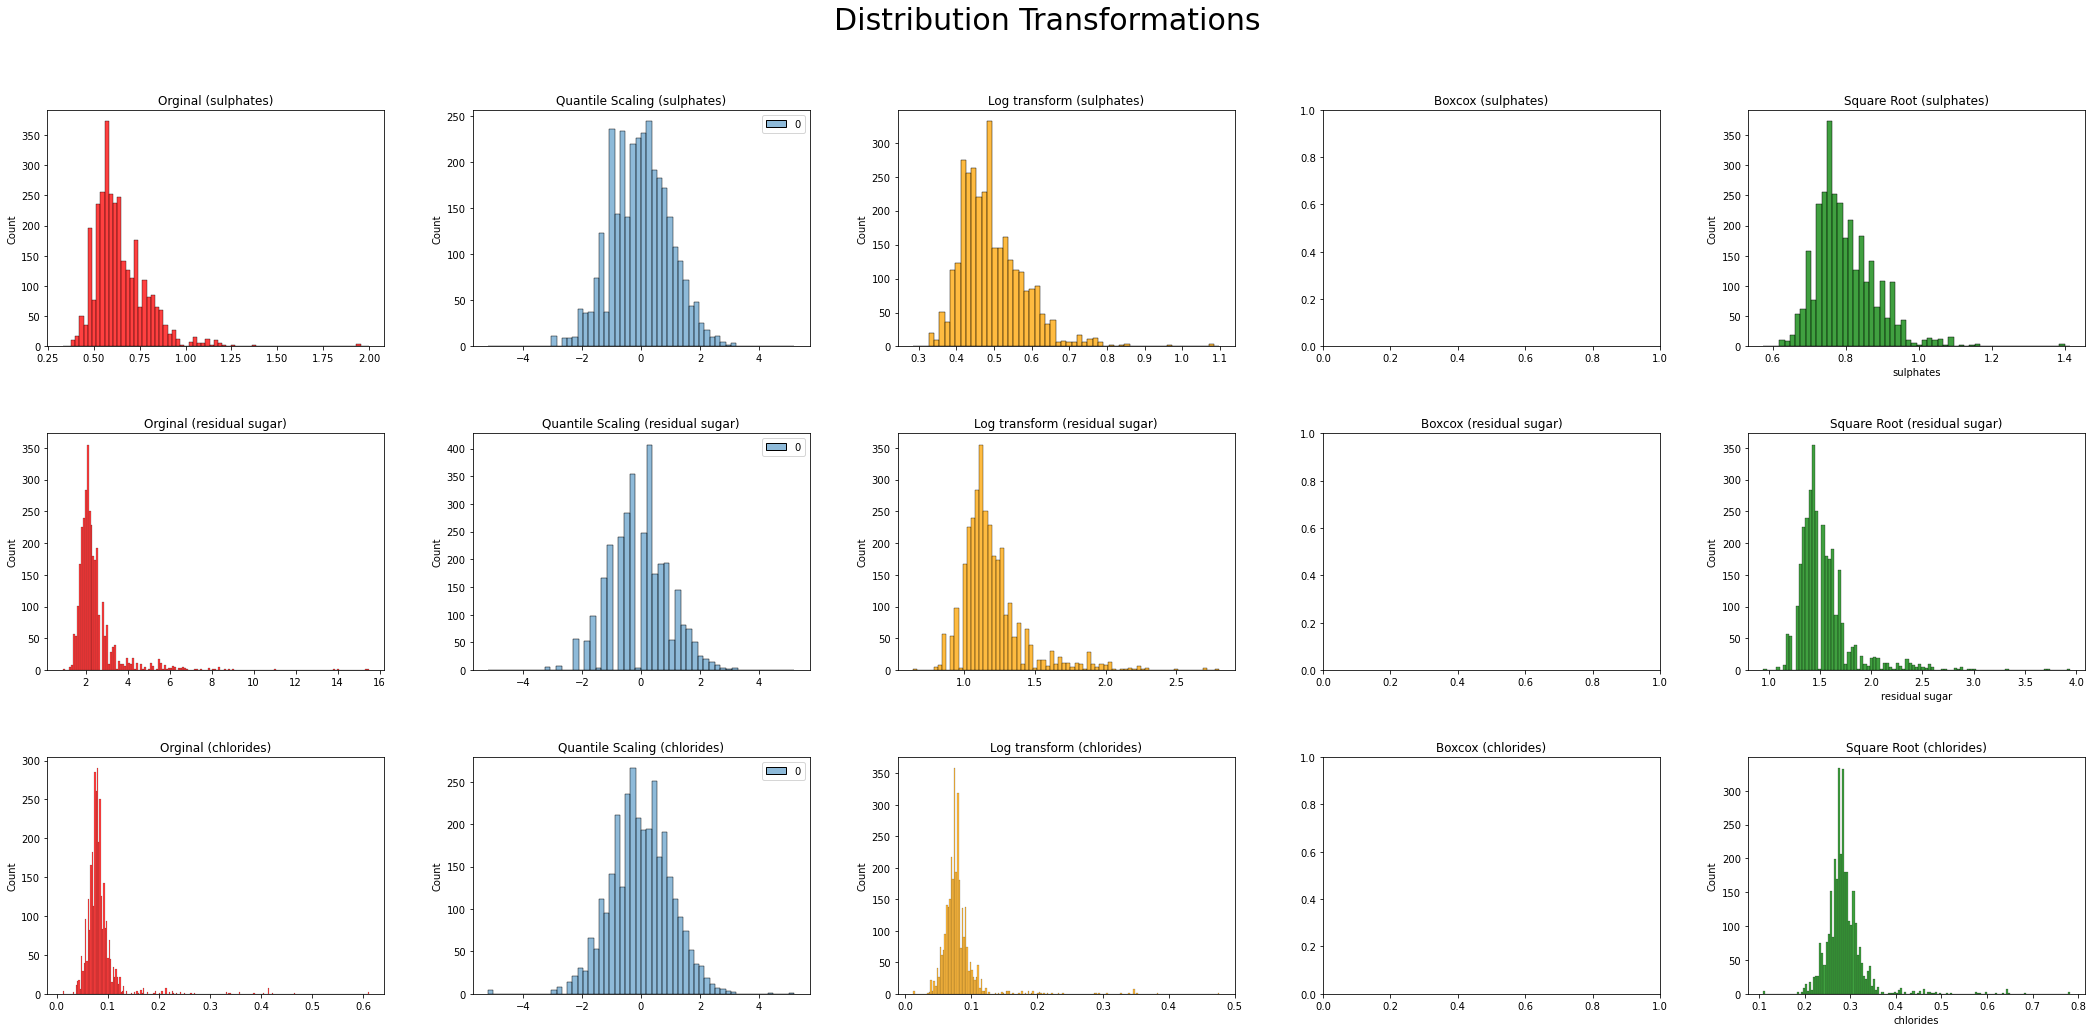

In [11]:
fig,ax = plt.subplots(len(affected_cols),5, figsize = (30,15))
for i,col in enumerate(affected_cols):
    #scale
    scaler = QuantileTransformer(output_distribution="normal")
    quant_df = scaler.fit_transform(combined_df[[col]])

    sns.histplot(x= combined_df[col],ax= ax[i,0],color = "red")
    sns.histplot(quant_df,ax= ax[i,1] )
    sns.histplot(np.log1p(combined_df[col]), ax = ax[i,2], color= "orange")
    try:
        sns.histplot(boxcox(combined_df[col])[0], ax = ax[i,3], color= "yellow")
    except:
        pass
    sns.histplot(np.sqrt(combined_df[col]), ax = ax[i,4], color= "green")
    ax[i,0].set_title(f"Orginal ({col})")
    ax[i,0].set(xlabel=None)
    ax[i,1].set_title(f"Quantile Scaling ({col})")
    ax[i,2].set_title(f"Log transform ({col})")
    ax[i,2].set(xlabel=None)
    ax[i,3].set_title(f"Boxcox ({col})")
    ax[i,4].set_title(f"Square Root ({col})")
plt.suptitle("Distribution Transformations",fontsize = 30)
plt.tight_layout(pad = 4)
plt.show()

#### Insights
* Quantile Scaling works best to give us a nice bell-shaped curve.
* BoxCox does not work on negative values. hence, the plots are absent.

#### Applying Quantile Scaling on our data to handle Skewness and Kurtosis

In [12]:
scaler = QuantileTransformer(output_distribution="normal")
combined_df[features] = pd.DataFrame(scaler.fit_transform(combined_df[features]))
test_df[features] = pd.DataFrame(scaler.fit_transform(test_df[features]))

In [13]:
# We concatenate test data to train to get a full view of the data as we know it
skew_df = pd.concat((combined_df.drop(TARGET,axis =1), test_df), axis =0).skew(numeric_only=True).sort_values()
kurtosis_df = pd.concat((combined_df.drop(TARGET,axis =1), test_df), axis =0).kurtosis().sort_values()
print("Skewly distributed columns by skewness value:\n") 
display(skew_df)
print("Kurtosis distributed columns by skewness value:\n") 
display(kurtosis_df)

Skewly distributed columns by skewness value:



citric acid            -1.708381
chlorides              -0.078784
alcohol                -0.014838
pH                     -0.004217
volatile acidity        0.001750
sulphates               0.006262
residual sugar          0.022555
density                 0.030040
fixed acidity           0.037543
free sulfur dioxide     0.040322
total sulfur dioxide    0.073334
dtype: float64

Kurtosis distributed columns by skewness value:



sulphates               0.269578
residual sugar          0.309148
alcohol                 0.425792
fixed acidity           0.436340
total sulfur dioxide    0.584635
volatile acidity        0.590570
pH                      0.598235
density                 0.761277
chlorides               0.807206
free sulfur dioxide     1.153332
citric acid             2.653648
dtype: float64

#### Handling Outliers

In [74]:
# def handle_outliers(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
#     for column in columns:
#         q1 = df[column].quantile(0.25)
#         q3 = df[column].quantile(0.75)
#         iqr_range = q3 - q1
        
#         upper_cap = q3 + 2.5*iqr_range
#         lower_cap = q1 - 2.5*iqr_range
        
#         df[column] = np.clip(df[column], lower_cap, upper_cap)
#     return df

In [ ]:
# combined_df = handle_outliers(combined_df, features)

#### Correlation Matrix


In [14]:
correlation = combined_df.corr()

print(correlation[TARGET].sort_values(ascending=False),'\n')

quality                 1.000000
alcohol                 0.472645
sulphates               0.377924
citric acid             0.123818
fixed acidity           0.070467
residual sugar          0.035711
pH                     -0.006670
free sulfur dioxide    -0.052397
chlorides              -0.119224
density                -0.165954
total sulfur dioxide   -0.186172
volatile acidity       -0.290142
Name: quality, dtype: float64 



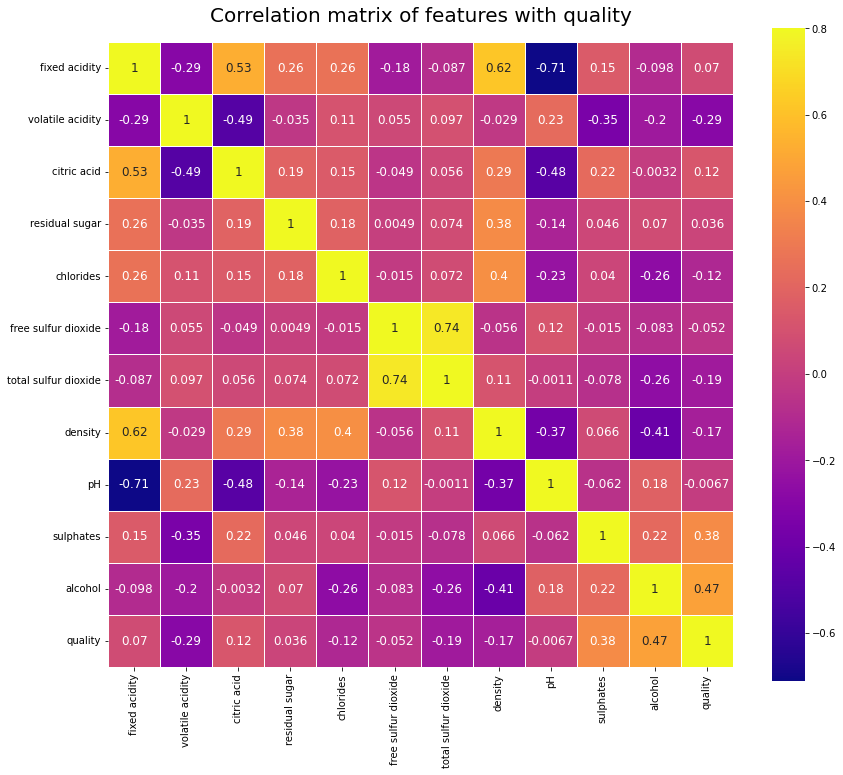

In [15]:
cols = correlation.index
corr_matrix = np.corrcoef(combined_df.to_numpy().T)

# Create a heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, vmax=.8, linewidths=0.5, square=True, annot=True,
            cmap='plasma', annot_kws={'size': 12}, xticklabels=cols, yticklabels=cols)

# Add title to the plot
plt.title(f'Correlation matrix of features with {TARGET}', fontsize=20, pad=20)

# Increase the size of axes values
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)

plt.show()

In [16]:
# Threshold for correlation value
threshold = 0.5

# Get the high-correlated pairs of columns, excluding auto-correlations
corr_pairs = (
    correlation[abs(correlation) > threshold][correlation != 1.0]
).unstack().dropna().to_dict()

# Remove duplicate pairs and create a dataframe with unique pairs
unique_corr_pairs = pd.DataFrame(
    list(
        set([(tuple(sorted(key)), corr_pairs[key]) for key in corr_pairs])
    ), columns=['pair', 'corr']
)

# Show the unique pairs and their correlation value
unique_corr_pairs

,pair,corr
0,"(density, fixed acidity)",0.620330
1,"(fixed acidity, pH)",-0.710053
2,"(free sulfur dioxide, total sulfur dioxide)",0.737389
3,"(citric acid, fixed acidity)",0.526313


#### Insights
* Alcohol and sulphates are positively correlated with quality.
* Many columns (as above) have a high degree of correlation among themselves

#### Studying the Target Variable

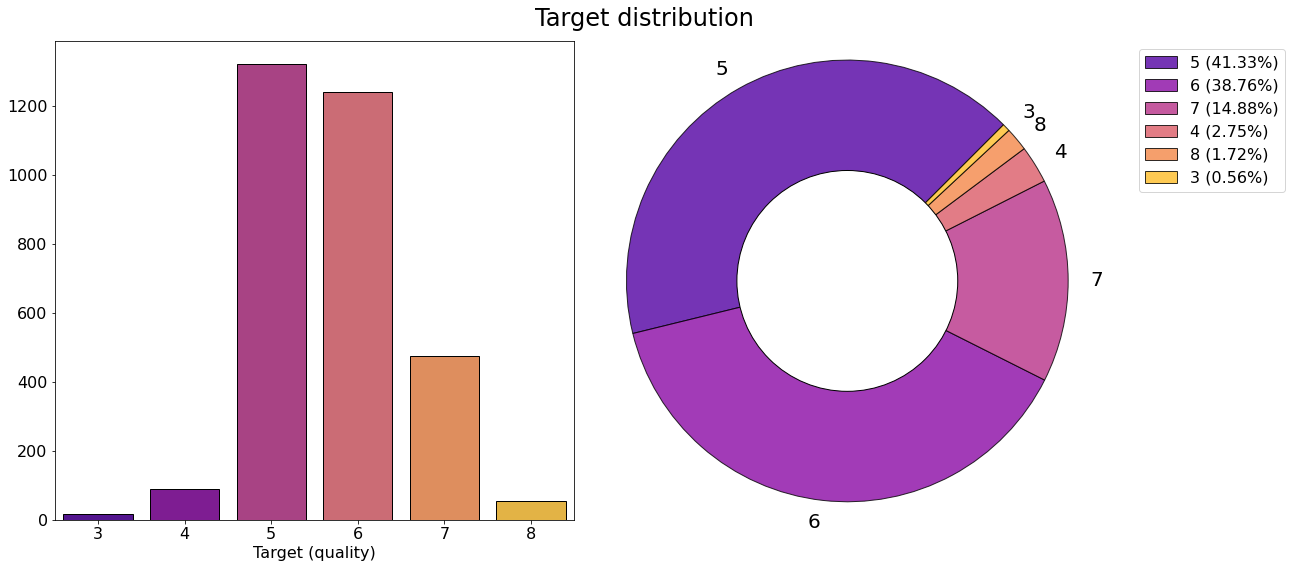

In [17]:
# Create the figure and subplots
TARGET = 'quality'
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Target distribution', fontsize=24)

# Plot the countplot
sns.countplot(x=TARGET, data=combined_df, alpha=1, palette=palette, edgecolor='black', ax=ax[0])
ax[0].set_xlabel(f'Target ({TARGET})', fontsize=16)
ax[0].set_ylabel('')
ax[0].tick_params(axis='both', labelsize=16)

# Get the counts of each class in the target column
target_counts = combined_df[TARGET].value_counts()

# Plot the pie chart
ax[1].pie(target_counts, labels=target_counts.index, startangle=45, colors=palette, pctdistance=0.3,
          textprops={'fontsize': 20}, wedgeprops={'alpha': 0.8, 'edgecolor': 'black', 'linewidth': 1})
ax[1].axis('equal')  # Ensure the pie is drawn as a circle

# Add the legend with target values and percentage
legend_entries = [f'{label} ({count/len(combined_df)*100:.2f}%)' for label, count in target_counts.items()]
ax[1].legend(legend_entries, bbox_to_anchor=(1.05, 1), loc='best', fontsize=16)

# Draw circle
centre_circle = plt.Circle((0, 0), 0.5, fc='white', edgecolor='black')
fig = plt.gcf()
  
# Adding circle in Pie chart
fig.gca().add_artist(centre_circle)

# Tighten the layout and show the figure
plt.tight_layout()
plt.show()

#### Insights:
* Target variable - quality is highly imbalanced. It makes sense because there are more number of normal quality wines than there are extremely bad or good wines. (94.97% have 5,6,7 quality rating)
* quality can range between 0-10 but actually the range is from 3-8 in the dataset

## Train-Test split

In [ ]:
# X = combined_df.drop(columns=['quality'])
# print(X.shape)
# y = combined_df.quality
# print(y.shape)

In [ ]:
# X_train, X_valid, y_train, y_valid = train_test_split(X,y,
#                                                         test_size=0.1, 
#                                                         stratify=y, 
#                                                         random_state=SEED)

## Modeling

## Hyperparameter Search with Optuna

In [18]:
target_clases = combined_df[TARGET].value_counts()
n_classes = target_clases.nunique()

In [19]:
def objective(trial):        
    params_optuna = {
            'max_depth': trial.suggest_int('max_depth', 1, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            #'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            #'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0.01, 1.0),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0001, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0001, 1.0),
            'objective' : " multi:softmax",
            'num_class': n_classes,
            'tree_method': 'gpu_hist'
        }

        
    n=trial.suggest_int('n_cv', 3, 10)
    cv = StratifiedKFold(n,shuffle=True, random_state=SEED)
    fold_scores = []
    for i, (train_idx,val_idx) in enumerate(cv.split(combined_df[features],combined_df[TARGET])):
        X_train, y_train = combined_df.loc[train_idx, features],combined_df.loc[train_idx, TARGET]
        X_val, y_val = combined_df.loc[val_idx, features],combined_df.loc[val_idx, TARGET]

        model = XGBClassifier(**params_optuna)
        model.fit(X_train,
                 y_train,
                 eval_set= [(X_val,y_val)],
                 early_stopping_rounds = 50,
                 verbose=500)

        pred_val = model.predict(X_val)

        score = cohen_kappa_score(y_val,pred_val, weights='quadratic')
        fold_scores.append(score)
    return np.mean(fold_scores)

In [20]:
combined_df[TARGET] = combined_df[TARGET]- 3 #xgb wants TARGET to start at 0

In [21]:
study = optuna.create_study(direction='maximize', sampler = TPESampler())
study.optimize(func=objective, n_trials=500)
study.best_params

[I 2023-02-06 18:32:27,241] A new study created in memory with name: no-name-f57a5c35-0ce2-4ff3-849f-265373c2eaf7


[0]	validation_0-mlogloss:1.47663
[75]	validation_0-mlogloss:0.98058
[0]	validation_0-mlogloss:1.47695
[70]	validation_0-mlogloss:0.97625
[0]	validation_0-mlogloss:1.48453
[99]	validation_0-mlogloss:0.94570
[0]	validation_0-mlogloss:1.48937
[99]	validation_0-mlogloss:0.99254
[0]	validation_0-mlogloss:1.48558
[74]	validation_0-mlogloss:0.97147
[0]	validation_0-mlogloss:1.49671
[99]	validation_0-mlogloss:0.97544
[0]	validation_0-mlogloss:1.48618
[64]	validation_0-mlogloss:1.02364
[0]	validation_0-mlogloss:1.47575
[80]	validation_0-mlogloss:0.97633


[I 2023-02-06 18:32:34,210] Trial 0 finished with value: 0.5012652771893975 and parameters: {'max_depth': 3, 'learning_rate': 0.35003282214743325, 'gamma': 0.3761425945246915, 'subsample': 0.9965324799161301, 'colsample_bytree': 0.9327653324604561, 'reg_alpha': 0.3152377019486581, 'reg_lambda': 0.5815520161863544, 'n_cv': 8}. Best is trial 0 with value: 0.5012652771893975.


[0]	validation_0-mlogloss:1.31804
[58]	validation_0-mlogloss:1.12232
[0]	validation_0-mlogloss:1.33550
[58]	validation_0-mlogloss:1.09637
[0]	validation_0-mlogloss:1.34459
[63]	validation_0-mlogloss:1.09722
[0]	validation_0-mlogloss:1.30925
[59]	validation_0-mlogloss:1.07975


[I 2023-02-06 18:32:35,315] Trial 1 finished with value: 0.49127818574964344 and parameters: {'max_depth': 3, 'learning_rate': 0.6260775709571718, 'gamma': 0.12898658024515544, 'subsample': 0.5536424403971693, 'colsample_bytree': 0.5425468280456627, 'reg_alpha': 0.2685300490580206, 'reg_lambda': 0.8554455903741496, 'n_cv': 4}. Best is trial 0 with value: 0.5012652771893975.


[0]	validation_0-mlogloss:1.47055
[63]	validation_0-mlogloss:1.09625
[0]	validation_0-mlogloss:1.47860
[58]	validation_0-mlogloss:1.09735
[0]	validation_0-mlogloss:1.47780
[59]	validation_0-mlogloss:1.09911


[I 2023-02-06 18:32:36,872] Trial 2 finished with value: 0.4966630973987283 and parameters: {'max_depth': 9, 'learning_rate': 0.3737013723209257, 'gamma': 0.4446590216598068, 'subsample': 0.654535072888801, 'colsample_bytree': 0.7395096505478138, 'reg_alpha': 0.4753732781150797, 'reg_lambda': 0.6069978854724211, 'n_cv': 3}. Best is trial 0 with value: 0.5012652771893975.


[0]	validation_0-mlogloss:1.63474
[86]	validation_0-mlogloss:0.98728
[0]	validation_0-mlogloss:1.63892
[93]	validation_0-mlogloss:1.01974
[0]	validation_0-mlogloss:1.63862
[85]	validation_0-mlogloss:1.02446


[I 2023-02-06 18:32:38,385] Trial 3 finished with value: 0.49687090822890373 and parameters: {'max_depth': 5, 'learning_rate': 0.1659963764327738, 'gamma': 0.917542753873411, 'subsample': 0.5616177547172783, 'colsample_bytree': 0.6727286049389583, 'reg_alpha': 0.36072685649713665, 'reg_lambda': 0.37157723603930815, 'n_cv': 3}. Best is trial 0 with value: 0.5012652771893975.


[0]	validation_0-mlogloss:1.74494
[99]	validation_0-mlogloss:0.95507
[0]	validation_0-mlogloss:1.74774
[99]	validation_0-mlogloss:0.99632
[0]	validation_0-mlogloss:1.74799
[99]	validation_0-mlogloss:0.98061
[0]	validation_0-mlogloss:1.74427
[99]	validation_0-mlogloss:0.96655
[0]	validation_0-mlogloss:1.74614
[99]	validation_0-mlogloss:0.97830
[0]	validation_0-mlogloss:1.74550
[99]	validation_0-mlogloss:0.99649


[I 2023-02-06 18:32:53,666] Trial 4 finished with value: 0.5258918797749191 and parameters: {'max_depth': 9, 'learning_rate': 0.04414582894839941, 'gamma': 0.2612222456675264, 'subsample': 0.8596417599469732, 'colsample_bytree': 0.7404701495898529, 'reg_alpha': 0.05135854067659966, 'reg_lambda': 0.3321154097410128, 'n_cv': 6}. Best is trial 4 with value: 0.5258918797749191.


[0]	validation_0-mlogloss:1.34109
[56]	validation_0-mlogloss:1.27297
[0]	validation_0-mlogloss:1.33172
[55]	validation_0-mlogloss:1.21326
[0]	validation_0-mlogloss:1.35394
[56]	validation_0-mlogloss:1.19228
[0]	validation_0-mlogloss:1.34324
[55]	validation_0-mlogloss:1.20127


[I 2023-02-06 18:32:56,218] Trial 5 finished with value: 0.47790019576966974 and parameters: {'max_depth': 8, 'learning_rate': 0.6014974677967093, 'gamma': 0.16727249865008634, 'subsample': 0.5398632858284227, 'colsample_bytree': 0.6690207099632911, 'reg_alpha': 0.7127868010475905, 'reg_lambda': 0.6752637335386321, 'n_cv': 4}. Best is trial 4 with value: 0.5258918797749191.


[0]	validation_0-mlogloss:1.45349
[64]	validation_0-mlogloss:1.02041
[0]	validation_0-mlogloss:1.46475
[67]	validation_0-mlogloss:1.05343
[0]	validation_0-mlogloss:1.46232
[65]	validation_0-mlogloss:1.04045
[0]	validation_0-mlogloss:1.46528
[63]	validation_0-mlogloss:1.05239
[0]	validation_0-mlogloss:1.48222
[69]	validation_0-mlogloss:1.04944
[0]	validation_0-mlogloss:1.46822
[62]	validation_0-mlogloss:1.06755


[I 2023-02-06 18:32:58,303] Trial 6 finished with value: 0.510973013559986 and parameters: {'max_depth': 4, 'learning_rate': 0.38708159002807885, 'gamma': 0.5816438719610526, 'subsample': 0.6883954750802534, 'colsample_bytree': 0.5361633427223331, 'reg_alpha': 0.336145680760447, 'reg_lambda': 0.2580666863918071, 'n_cv': 6}. Best is trial 4 with value: 0.5258918797749191.


[0]	validation_0-mlogloss:1.25439
[54]	validation_0-mlogloss:1.19225
[0]	validation_0-mlogloss:1.26072
[60]	validation_0-mlogloss:1.19469
[0]	validation_0-mlogloss:1.27236
[55]	validation_0-mlogloss:1.15011
[0]	validation_0-mlogloss:1.25848
[54]	validation_0-mlogloss:1.19994


[I 2023-02-06 18:32:59,738] Trial 7 finished with value: 0.48624800628279513 and parameters: {'max_depth': 4, 'learning_rate': 0.7285592889792268, 'gamma': 0.8843045317088287, 'subsample': 0.5458156812883664, 'colsample_bytree': 0.8202138110661272, 'reg_alpha': 0.4287756554193104, 'reg_lambda': 0.674115884524987, 'n_cv': 4}. Best is trial 4 with value: 0.5258918797749191.


[0]	validation_0-mlogloss:1.27417
[54]	validation_0-mlogloss:1.35931
[0]	validation_0-mlogloss:1.30793
[51]	validation_0-mlogloss:1.47317
[0]	validation_0-mlogloss:1.29821
[55]	validation_0-mlogloss:1.42580
[0]	validation_0-mlogloss:1.30820
[52]	validation_0-mlogloss:1.52343
[0]	validation_0-mlogloss:1.26999
[52]	validation_0-mlogloss:1.34687
[0]	validation_0-mlogloss:1.32184
[52]	validation_0-mlogloss:1.36753
[0]	validation_0-mlogloss:1.33780
[53]	validation_0-mlogloss:1.41063


[I 2023-02-06 18:33:02,641] Trial 8 finished with value: 0.476567127114521 and parameters: {'max_depth': 7, 'learning_rate': 0.74683100099698, 'gamma': 0.5030737708763046, 'subsample': 0.5017227159545077, 'colsample_bytree': 0.5644248737909487, 'reg_alpha': 0.06560778384699559, 'reg_lambda': 0.05146140474217207, 'n_cv': 7}. Best is trial 4 with value: 0.5258918797749191.


[0]	validation_0-mlogloss:1.71882
[99]	validation_0-mlogloss:0.96971
[0]	validation_0-mlogloss:1.71510
[99]	validation_0-mlogloss:0.90646
[0]	validation_0-mlogloss:1.72166
[99]	validation_0-mlogloss:0.97324
[0]	validation_0-mlogloss:1.72069
[99]	validation_0-mlogloss:0.98575
[0]	validation_0-mlogloss:1.72265
[99]	validation_0-mlogloss:0.99524
[0]	validation_0-mlogloss:1.71954
[99]	validation_0-mlogloss:0.94667
[0]	validation_0-mlogloss:1.71860
[99]	validation_0-mlogloss:0.92457
[0]	validation_0-mlogloss:1.72192
[99]	validation_0-mlogloss:0.99650
[0]	validation_0-mlogloss:1.71576
[99]	validation_0-mlogloss:0.98555
[0]	validation_0-mlogloss:1.71996
[99]	validation_0-mlogloss:0.94354


[I 2023-02-06 18:33:10,769] Trial 9 finished with value: 0.5143150433649423 and parameters: {'max_depth': 6, 'learning_rate': 0.07560959912151452, 'gamma': 0.7625779810169215, 'subsample': 0.7137398084868398, 'colsample_bytree': 0.5222987216729318, 'reg_alpha': 0.7987219040319363, 'reg_lambda': 0.7077914717817134, 'n_cv': 10}. Best is trial 4 with value: 0.5258918797749191.


[0]	validation_0-mlogloss:1.76660
[99]	validation_0-mlogloss:1.02493
[0]	validation_0-mlogloss:1.76919
[99]	validation_0-mlogloss:1.06263
[0]	validation_0-mlogloss:1.76855
[99]	validation_0-mlogloss:1.05201
[0]	validation_0-mlogloss:1.76815
[99]	validation_0-mlogloss:1.03530
[0]	validation_0-mlogloss:1.76788
[99]	validation_0-mlogloss:1.05909
[0]	validation_0-mlogloss:1.76864
[99]	validation_0-mlogloss:1.06492


[I 2023-02-06 18:33:33,242] Trial 10 finished with value: 0.5270025933592787 and parameters: {'max_depth': 10, 'learning_rate': 0.022238841593620738, 'gamma': 0.0304256064560873, 'subsample': 0.8489609216747523, 'colsample_bytree': 0.8760713408919074, 'reg_alpha': 0.032086675480043084, 'reg_lambda': 0.3669957696861048, 'n_cv': 6}. Best is trial 10 with value: 0.5270025933592787.


[0]	validation_0-mlogloss:1.76962
[99]	validation_0-mlogloss:1.04155
[0]	validation_0-mlogloss:1.77120
[99]	validation_0-mlogloss:1.07861
[0]	validation_0-mlogloss:1.77141
[99]	validation_0-mlogloss:1.07211
[0]	validation_0-mlogloss:1.77004
[99]	validation_0-mlogloss:1.05140
[0]	validation_0-mlogloss:1.76990
[99]	validation_0-mlogloss:1.07433
[0]	validation_0-mlogloss:1.77066


[W 2023-02-06 18:33:52,294] Trial 11 failed with parameters: {'max_depth': 10, 'learning_rate': 0.020395221114749475, 'gamma': 0.042935057739648105, 'subsample': 0.8556508730602197, 'colsample_bytree': 0.8778038210676804, 'reg_alpha': 0.008195855085471326, 'reg_lambda': 0.406258935081587, 'n_cv': 6} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_23/1338489446.py", line 30, in objective
    verbose=500)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 1411, in fit
    callbacks=callbacks,
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py",

KeyboardInterrupt: 

## Ensembling with XGB and LGBM classifiers

In [23]:
k=10
cv = StratifiedKFold(k, shuffle=True, random_state=42)
fold_scores = []
test_preds = []
oof_preds = []
oof_true = []

for i, (train_idx,val_idx) in enumerate(cv.split(combined_df[features],
                                                 combined_df[TARGET])):
    
    X_train = combined_df.loc[train_idx, features]
    y_train = combined_df.loc[train_idx, TARGET]
    X_val = combined_df.loc[val_idx, features]
    y_val = combined_df.loc[val_idx, TARGET]
    
    #**************XGB**************
    
    params_xgb = {'max_depth': 7, 'learning_rate': 0.1693552227182279, 'gamma': 0.011185093635433158, 'subsample': 0.8105625764399811, 'colsample_bytree': 0.8150622795420766, 'reg_alpha': 0.4976758262122119, 'reg_lambda': 0.5979036234853471, 
                  'objective' : " multi:softmax",
                  'n_estimators':10000,
                  'num_class': n_classes,
                 }
    
    model1 = XGBClassifier(**params_xgb)
    model1.fit(X_train,
             y_train,
             eval_set= [(X_val,y_val)],
             early_stopping_rounds = 200,
             verbose=200)
    
    pred_val1 = model1.predict(X_val)
    
    score1 = cohen_kappa_score(y_val,pred_val1, weights='quadratic')
    #discard the predictions of poor performing models
    if score1>0.36:
        test_preds.append(model1.predict(test_df[features]))
        fold_scores.append(score1)
    
    #************** Light GBM **************
    
    params_lgbm = {'lambda_l1': 1.9528554374745727e-09,
                 'lambda_l2': 6.288470302197343,
                 'num_leaves': 50,
                 'feature_fraction': 0.8253409987746099,
                 'bagging_fraction': 0.6280124722436471,
                 'bagging_freq': 4,
                 'min_child_samples': 85,
                 'min_data_in_leaf': 93,
                 'max_depth': 8,
                 'num_iterations':10000,
                 'objective' : "multiclass",
                 'metric' :'multi_logloss'}
    
    model2 = LGBMClassifier(**params_lgbm)
    model2.fit(X_train,
             y_train,
             eval_set= [(X_val,y_val)],
             early_stopping_rounds = 200,
             verbose=200)
    
    pred_val2 = model2.predict(X_val)
    
    score2 = cohen_kappa_score(y_val,pred_val2, weights='quadratic')
    #discard the predictions of poor performing models
    if score2>0.36:
        test_preds.append(model2.predict(test_df[features]))
        fold_scores.append(score2)
    
    oof_preds.extend(np.mean([pred_val1,pred_val2],axis=0))
    oof_true.extend(y_val)
    print(f'=== Fold {i} Cohen Kappa Score {np.mean([score1,score2])} ===')

print(f'=== Average Cohen Kappa Score {np.mean(fold_scores)} ===')
    

[0]	validation_0-mlogloss:1.61753
[200]	validation_0-mlogloss:1.20928
[227]	validation_0-mlogloss:1.22572
[LightGBM] [Warning] lambda_l1 is set=1.9528554374745727e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9528554374745727e-09
[LightGBM] [Warning] bagging_fraction is set=0.6280124722436471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6280124722436471
[LightGBM] [Warning] lambda_l2 is set=6.288470302197343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.288470302197343
[LightGBM] [Warning] feature_fraction is set=0.8253409987746099, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8253409987746099
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[200]	valid_0's multi_logloss: 1.08386
=== Fold 0 Cohen Kappa Score 0.5155081456216704 ===

#### Threshold Tuning

In [24]:
class OptunaRounder:

    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        self.labels = np.unique(y_true)

    def __call__(self, trial):
        thresholds = []
        for i in range(len(self.labels) - 1):
            low = max(thresholds) if i > 0 else min(self.labels)
            high = max(self.labels)
            t = trial.suggest_float(f't{i}', low, high)
            thresholds.append(t)
        try:
            opt_y_pred = self.adjust(self.y_pred, thresholds)
        except: return 0
        return cohen_kappa_score(self.y_true, opt_y_pred, weights='quadratic')

    def adjust(self, y_pred, thresholds):
        opt_y_pred = pd.cut(y_pred,
                            [-np.inf] + thresholds + [np.inf],
                            labels=self.labels)
        return opt_y_pred

In [25]:
optuna.logging.set_verbosity(optuna.logging.WARNING) 
objective = OptunaRounder(oof_true, oof_preds)
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, timeout=100)

In [37]:
# Best thresholds & score
best_thresholds = sorted(study.best_params.values())
print(f'Optimized thresholds: {best_thresholds}')

oof_pred_opt = objective.adjust(oof_preds, best_thresholds)
best_score = cohen_kappa_score(oof_true, oof_pred_opt, weights='quadratic')
print(f'Optimized OOF Score: {best_score:.5f}')

Optimized thresholds: [0.7790361752767436, 1.2653033930711362, 2.8362420381032583, 3.4910725614762486, 4.190946998201012]
Optimized OOF Score: 0.55004


In [ ]:
# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=cohen_kappa_score)
# models,predictions = clf.fit(X_train, X_valid, y_train, y_valid)
# models

In [ ]:
# import lightgbm as lgb
# clf = lgb.LGBMClassifier()
# clf.fit(X_train, y_train)

## Submission

In [38]:
# ytest_pred = clf.predict(test_df)
test_preds = np.array(test_preds).mean(axis=0) 

AxisError: axis 0 is out of bounds for array of dimension 0

In [35]:
test_preds

2.3999999999999995

In [34]:
output = sample_submission.copy()
opt_test_preds = objective.adjust(test_preds, best_thresholds).astype(int) +3
output[TARGET] = opt_test_preds
output.head()

ValueError: Input array must be 1 dimensional

In [30]:
output.to_csv('./solution.csv', index=False)

### Reference notebooks that helped:
I have rigorously looked at the below notebooks and picked out points that made sense to me the most. I am trying to learn as much as I can from notebooks presented by the expert contributors mentioned below to reach a point where I can put together my own notebook soon :)

- https://www.kaggle.com/code/phongnguyen1/yet-another-eda/notebook
- https://www.kaggle.com/code/abhi011097/s3-e5-eda-multi-approach-models-w-o-smote
- https://www.kaggle.com/code/maxencefzr/ps-s3e5-eda-modelling-ensembling
- https://www.kaggle.com/code/slythe/ultimate-eda-model-selection-pse3e5#%F0%9F%91%A8%F0%9F%8F%BC%E2%80%8D%F0%9F%8C%BE-Distribution-Transformations:-%F0%9F%91%A8%F0%9F%8F%BC%E2%80%8D%F0%9F%8C%BE